# Bayesian Structured Time Series

### The Great NeurIPS 2025 Taco Forecast 🌮

**Location**: San Diego, CA **Objective**: Decompose the latent drivers of Al Pastor consumption.

Welcome to San Diego\! You are attending **NeurIPS 2025**. Between the Deep Learning keynotes and the poster sessions, there is one variable that dominates the conference dynamics: **The hunger for Tacos.**

We suspect that local weather plays a role (San Diegans are notoriously sensitive to the cold), but it implies only part of the story. There are hidden rhythms—weekly cycles, trend shifts, and random shocks—that govern the lines at the taqueria.

In this notebook, we will build a **Bayesian Structured Time Series (STS)** model using `RxInfer.jl` to predict this demand.

This notebook is inspired by the excellent STS repository from [here (sts-jax)](https://github.com/probml/sts-jax).

We are going to extend it by **treating the transition dynamics matrix** (which governs the frequency and damping of these cycles) as a collection of **unknown random variables** and learn them simultaneously with the states. Instead of hard-coding "Taco Tuesday" to exactly 7 days, we let the model discover the rhythm.

## 1\. Setup & Data Generation

We need `RxInfer` for the probabilistic inference and `HTTP` to fetch real San Diego weather data to ground our simulation in reality.

In [18]:
using RxInfer, LinearAlgebra, Statistics, Plots, StableRNGs
using HTTP, JSON3, DataFrames, Dates, Random, Distributions

# wait for a twist 
using ClosedFormExpectations
using ExponentialFamilyProjection

theme(:wong)

rng = StableRNG(42)

println("Libraries loaded. Preparation for consumption initiated.")

Libraries loaded. Preparation for consumption initiated.


### The Data: "World Knowledge" Logic

We don't have the actual sales ledger from the taqueria yet, so we will generate a **Taco Demand Index** based on real weather history and some "World Knowledge" assumptions:

1.  **The Patio Curve:** Humans prefer eating tacos outside at 72°F.
2.  **The Rain Penalty:** Rain kills the vibe.
3.  **The Calendar:** Tuesdays and Weekends imply higher demand.

📡 Fetching San Diego Weather...
Data Ready. Training on 987 days.


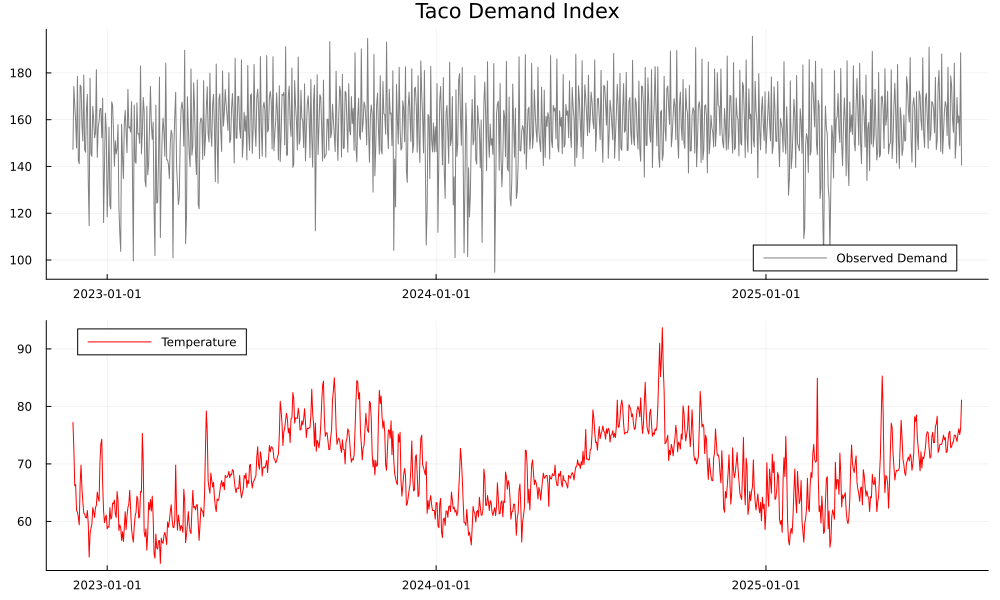

In [2]:
const LAT = 32.7157
const LON = -117.1611
const START_DATE = Date(today()) - Year(3)
const ARCHIVE_END_DATE = Date(today())

function fetch_real_weather()
    println("📡 Fetching San Diego Weather...")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = Dict(
        "latitude" => LAT, "longitude" => LON,
        "start_date" => string(START_DATE), "end_date" => string(ARCHIVE_END_DATE),
        "daily" => "temperature_2m_max,rain_sum",
        "temperature_unit" => "fahrenheit", "precipitation_unit" => "inch",
        "timezone" => "America/Los_Angeles"
    )
    query_str = join(["$k=$v" for (k,v) in params], "&")
    try
        resp = HTTP.get("$url?$query_str")
        data = JSON3.read(resp.body)
        return DataFrame(
            Date = Date.(String.(data.daily.time)),
            Max_Temp_F = Float64.(data.daily.temperature_2m_max),
            Rain_Inches = Float64.(data.daily.rain_sum)
        )
    catch e
        println("API Error."); rethrow(e)
    end
end

# Feel free to change the logic or use real data (please share!)
function calculate_taco_demand(df::DataFrame)
    scores = Float64[]
    for row in eachrow(df)
        d = 150.0
        # 1. Patio Curve (72F is peak)
        temp_factor = clamp(1.0 - (abs(row.Max_Temp_F - 72.0)/100.0)^1.5, 0.3, 1.0)
        d *= temp_factor
        # 2. Rain Penalty
        rain = row.Rain_Inches
        if rain > 0.5; d -= 40.0; elseif rain > 0.2; d -= 25.0; elseif rain > 0.05; d -= 15.0; end
        # 3. Calendar
        if dayofweek(row.Date) == 2; d += 35.0; end # Tuesday
        if dayofweek(row.Date) in [5, 6]; d += 20.0; elseif dayofweek(row.Date)==7; d += 12.0; end
        d += randn() * 5.0 # Noise
        push!(scores, clamp(d, 20.0, 250.0))
    end
    df.Taco_Demand_Index = round.(scores, digits=1)
    return df
end

df_weather_history = fetch_real_weather()
df_history = calculate_taco_demand(deepcopy(df_weather_history))
demand = df_history.Taco_Demand_Index
temperature = df_history.Max_Temp_F
dates = df_history.Date

# Split Train/Test
n_total = length(demand)
n_predict = round(Int, n_total * 0.1) # Holdout 10% of data
n_train = n_total - n_predict

println("Data Ready. Training on $n_train days.")
p1 = plot(dates[1:n_train], demand[1:n_train], label="Observed Demand", title="Taco Demand Index", color=:gray)
p2 = plot(dates[1:n_train], temperature[1:n_train], label="Temperature", color=:red)
plot(p1, p2, layout=(2,1), size=(1000, 600))

## 2\. The Gaussian STS Model

We define a State Space Model (SSM) with the following full formulation:

$$y_t = H_t z_t + x_t^T \beta + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma_t^2)$$
$$z_{t+1} = F_t z_t + R_t \eta_t, \quad \eta_t \sim N(0, Q_t)$$

### The Latent Dynamics

Our state vector $z_t$ has dimension $D=6$, representing:
`[Level, Daily_Cos, Daily_Sin, Weekly_Cos, Weekly_Sin, AR_Residual]`

#### a\. The Transition Matrix ($F$)

The transition matrix $F$ is constructed from **5 non-zero learnable components** (parameters), which we infer from data. These aren't just static numbers; they represent the physics of seasonality:

  * $F_1, F_2$: Control the **damping** and **rotation frequency** of the **Daily** cycle.
  * $F_3, F_4$: Control the **damping** and **rotation frequency** of the **Weekly** cycle.
  * $F_5$: Controls the decay rate of the **Autoregressive (AR)** trend.

  $$
  F(\theta) = \begin{pmatrix}
  1 & 0 & 0 & 0 & 0 & 0 \\
  0 & F_1 & F_2 & 0 & 0 & 0 \\
  0 & -F_2 & F_1 & 0 & 0 & 0 \\
  0 & 0 & 0 & F_3 & F_4 & 0 \\
  0 & 0 & 0 & -F_4 & F_3 & 0 \\
  0 & 0 & 0 & 0 & 0 & F_5
  \end{pmatrix}
  $$

#### b\. The Selection Matrix ($R$)

$R$ is a selection matrix, which is a subset of columns of the base vector $e_i$. It acts as a bridge, converting the non-singular covariance matrix $Q_t$ (of the lower-dimensional noise $\eta_t$) into the (possibly singular) covariance matrix of the latent state $z_t$.

In our case, we have 4 sources of noise driving 6 states (Level, Daily Base, Weekly Base, AR), so $R$ maps $\mathbb{R}^4 \to \mathbb{R}^6$.

In [3]:
# State Dimension
D = 6
# Observation Matrix: We sum Level(1) + Daily(2) + Weekly(4) + AR(6)
H_vec = [1.0, 1.0, 0.0, 1.0, 0.0, 1.0]

# Transition Function: Dynamically builds M based on parameter F
function transition(F)
    FT = eltype(F)
    M = zeros(FT, 6, 6)
    M[1,1] = one(FT) # Random Walk Trend
    
    # Daily Block (Rotation Matrix)
    M[2,2] = F[1]; M[2,3] = F[2]; 
    M[3,2] = -F[2]; M[3,3] = F[1]
    
    # Weekly Block (Rotation Matrix)
    M[4,4] = F[3]; M[4,5] = F[4]; 
    M[5,4] = -F[4]; M[5,5] = F[3]
    
    # AR Block
    M[6,6] = F[5]
    return M
end

transition (generic function with 1 method)

In [4]:
# The Gaussian STS Model
@model function rxsts(H, X, y, R, priors)
    # Hyperparameters
    τy    ~ priors[:τy]
    β     ~ priors[:β]
    # Prior for the covariance matrix Q
    Q     ~ Wishart(priors[:Q].df, priors[:Q].S)
    η     ~ MvNormal(mean=mean(priors[:η]), precision=Q)
    zprev ~ priors[:z0]
    F     ~ priors[:F] # Learning the 5 non-zero components
    
    for t in eachindex(y)
        # 1. State Transition
        # We use ContinuousTransition because M depends on the random variable F
        z₁[t] ~ ContinuousTransition(zprev, F, diageye(D)) # z₁[t] := F * z₁[t-1]
        z₂[t] ~ R * η
        z[t]  ~ z₁[t] + z₂[t]
        
        # 2. Observation
        μ[t]  ~ dot(H, z[t]) + dot(X[t], β)
        y[t]  ~ Normal(mean = μ[t], precision = τy)
        
        zprev = z[t]
    end
end

In [5]:
# Constraints & Meta
@constraints function rxsts_constraints()
    q(z, z₁, z₂, zprev, F, Q, η, μ, y, τy, β) = q(z, z₁, z₂, zprev,μ, y, β, η)q(F)q(Q)q(τy)
end

@meta function rxsts_meta()
    ContinuousTransition() -> CTMeta(transition)
end

rxsts_meta (generic function with 1 method)

### Inference

We prepare the priors and the $R$ matrix. Note that we center the temperature data (Regressors `X`) so the $\beta$ coefficient is interpretable as deviation from the mean.

In [6]:
# R Matrix: Selection matrix mapping noise to specific states
# Indices 1(Level), 2(Daily), 4(Weekly), 6(AR) get noise.
R = [1 0 0 0; 
     0 1 0 0; 
     0 0 0 0; 
     0 0 1 0; 
     0 0 0 0; 
     0 0 0 1]

# Data Prep
X_input = [[temp] for temp in temperature]
y_input = [demand[1:n_train]; fill(missing, n_predict)]

priors = Dict(
    :τy => GammaShapeRate(10.0, 1.0),
    :β  => MvNormalMeanPrecision(zeros(1), diageye(1)),
    :z0 => MvNormalMeanPrecision(ones(D), diageye(D)),
    :F  => MvNormalMeanPrecision(randn(rng, 5), diageye(5)),
    :Q  => Wishart(6, diagm([1.0, 1.0, 1.0, 1.0])),
    :η  => MvNormalMeanPrecision(zeros(4), diageye(4))
)

@initialization function rxsts_init(priors)
    q(F)  = priors[:F]
    q(Q)  = priors[:Q]
    q(τy) = priors[:τy]
    μ(z)  = priors[:z0]

end

results = infer(
    model = rxsts(H=H_vec, X=X_input, R=R, priors=priors),
    data = (y = y_input,),
    constraints = rxsts_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_init(priors),
    options = (limit_stack_depth = 100,),
    returnvars = KeepLast(),
    iterations = 15, # VMP Iterations
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Inference results:
  Posteriors       | available for (μ, F, τy, z₂, Q, z, β, η, zprev, z₁)
  Predictions      | available for (y)


### Visualization & Decomposition

Let's see what the model discovered:

In [7]:
# Extract learned Beta
β_mean = mean(results.posteriors[:β])[1]
β_var  = var(results.posteriors[:β])[1]
println("Learned Temperature Coefficient β:  $(round(β_mean, digits=3)) ± $(round(sqrt(β_var), digits=3))")

# Extract learned F
F_mean = transition(mean(results.posteriors[:F]))
println("Learned Transition Matrix F:")
display(F_mean)
z_means = mean.(results.posteriors[:z])
z_vars = var.(results.posteriors[:z]);


6×6 Matrix{Float64}:
 1.0   0.0        0.0        0.0       0.0        0.0
 0.0  -0.167348  -0.231574   0.0       0.0        0.0
 0.0   0.231574  -0.167348   0.0       0.0        0.0
 0.0   0.0        0.0        0.10447   0.158863   0.0
 0.0   0.0        0.0       -0.158863  0.10447    0.0
 0.0   0.0        0.0        0.0       0.0       -0.477284

Learned Temperature Coefficient β:  2.251 ± 0.008
Learned Transition Matrix F:


In [8]:
level_means, level_vars = getindex.(z_means, 1), getindex.(z_vars, 1)
daily_means, daily_vars = getindex.(z_means, 2), getindex.(z_vars, 2)
weekly_means, weekly_vars = getindex.(z_means, 4), getindex.(z_vars, 4)
ar_means, ar_vars = getindex.(z_means, 6), getindex.(z_vars, 6)
temp_means = β_mean .* temperature

pred_means = mean.(results.predictions[:y][end])
pred_vars = var.(results.predictions[:y][end]);

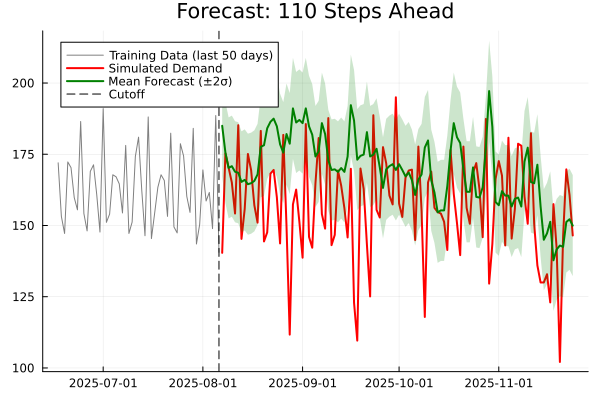

In [11]:

history_window = 50 

start_idx = max(1, n_train - history_window)

p_forecast = plot(dates[start_idx:n_train], demand[start_idx:n_train], 
    label="Training Data (last $history_window days)", color=:gray, 
    title="Forecast: $(n_predict) Steps Ahead",
    legend=:topleft
)

plot!(dates[n_train+1:end], demand[n_train+1:end], 
    label="Simulated Demand", color=:red, lw=2
)

# We assume pred_means aligns with the full dataset length
plot!(dates[n_train+1:end], pred_means[n_train+1:end], 
    ribbon=sqrt.(pred_vars[n_train+1:end]), 
    label="Mean Forecast (±2σ)", color=:green, fillalpha=0.2, lw=2
)

vline!([dates[n_train]], label="Cutoff", color=:black, linestyle=:dash)

display(p_forecast)

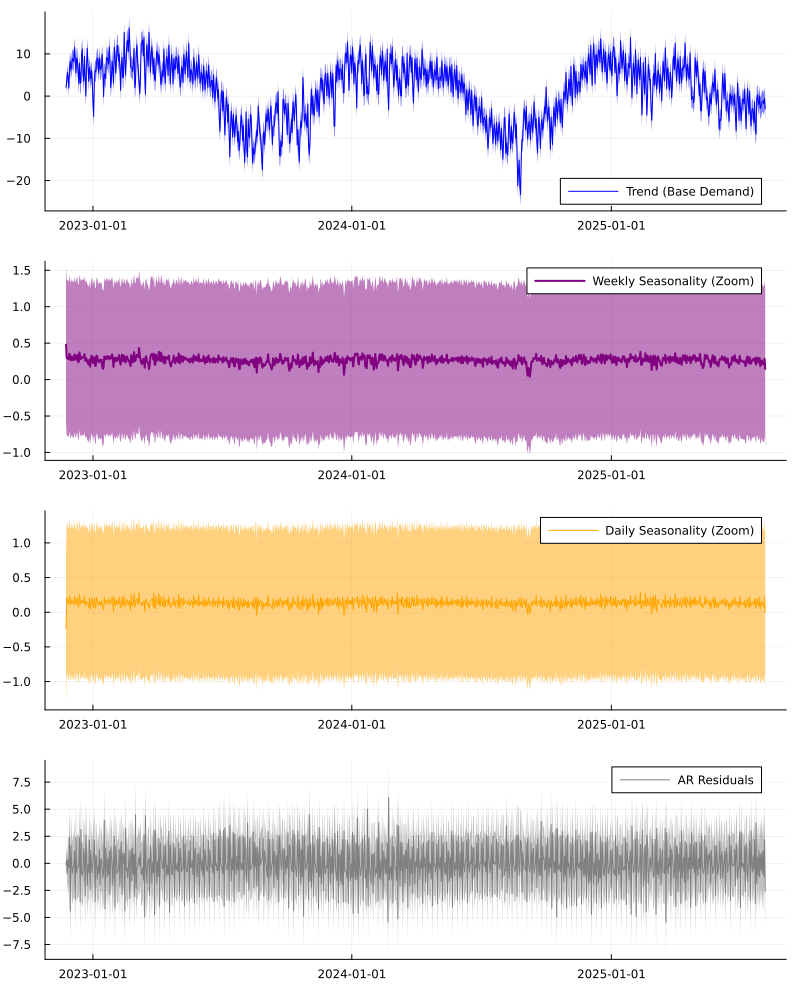

In [12]:
l = @layout [a; b; c; d]
p_trend = plot(dates[1:n_train], level_means[1:n_train], ribbon=sqrt.(level_vars[1:n_train]), label="Trend (Base Demand)", color=:blue)
p_week  = plot(dates[1:n_train], weekly_means[1:n_train], ribbon=sqrt.(weekly_vars[1:n_train]), label="Weekly Seasonality (Zoom)", color=:purple, lw=2)
p_daily = plot(dates[1:n_train], daily_means[1:n_train], ribbon=sqrt.(daily_vars[1:n_train]), label="Daily Seasonality (Zoom)", color=:orange)
p_ar    = plot(dates[1:n_train], ar_means[1:n_train], ribbon=sqrt.(ar_vars[1:n_train]), label="AR Residuals", color=:gray)

plot(p_trend, p_week, p_daily, p_ar, layout=l, size=(800, 1000))

And now! Let's predict some future! For that we need to download some predictions over the next 7 days [Note by the time you read this, it could be way beyond Neurips 2025, or even way beyond 2025 :D] but hope you could still use it for some tacos predictions in San Diego :D

In [13]:
function get_forecast(days::Int)
    println("📡 Fetching Forecast")
    url = "https://api.open-meteo.com/v1/forecast"
    params = Dict(
        "latitude" => LAT, "longitude" => LON,
        "daily" => "temperature_2m_max,rain_sum",
        "temperature_unit" => "fahrenheit",
        "forecast_days" => string(days), 
        "precipitation_unit" => "inch",
        "timezone" => "America/Los_Angeles"
    )
    query = join(["$k=$v" for (k,v) in params], "&")
    resp = HTTP.get("$url?$query")
    data = JSON3.read(resp.body)
    return DataFrame(
        Date = Date.(String.(data.daily.time)),
        Max_Temp_F = Float64.(data.daily.temperature_2m_max),
        Rain_Inches = Float64.(data.daily.rain_sum)
    )
end

get_forecast (generic function with 1 method)

### Showtime

Now, let's predict the future! We need to download weather forecasts for the next 14 days. (Note: By the time you read this, Neurips 2025 might be ancient history, but hopefully, the code still helps you find the best days for tacos in San Diego!)

In [14]:
days_ahead = 14

df_weather_future  = get_forecast(days_ahead)

df_weather_full = vcat(df_weather_history, df_weather_future)
unique!(df_weather_full, :Date)
sort!(df_weather_full, :Date)

df_demand_history = calculate_taco_demand(deepcopy(df_weather_history))
demand_history = df_demand_history.Taco_Demand_Index

temperature_full = df_weather_full.Max_Temp_F
dates_full = df_weather_full.Date;


X_input_future = [[temp] for temp in temperature_full]
y_input_future = [demand_history; fill(missing, days_ahead-1)]

results_future = infer(
    model = rxsts(H=H_vec, X=X_input_future, R=R, priors=priors),
    data = (y = y_input_future,),
    constraints = rxsts_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_init(priors),
    options = (limit_stack_depth = 100,),
    returnvars = KeepLast(),
    iterations = 15, # VMP Iterations
    showprogress = true
)

📡 Fetching Forecast


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (μ, F, τy, z₂, Q, z, β, η, zprev, z₁)
  Predictions      | available for (y)


In [15]:
y_pred_mean = mean.(results_future.predictions[:y][end])
y_pred_var = var.(results_future.predictions[:y][end]);

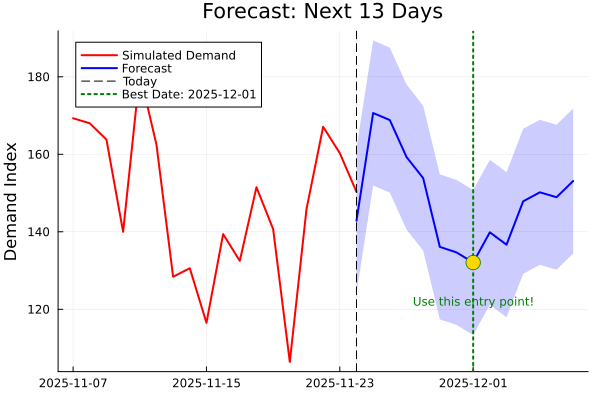

The optimal date for tacos is: 2025-12-01


In [16]:
n_view = 30
n_total = length(dates_full)
view_range = (n_total - n_view):n_total
n_train = length(demand_history)

# Indices
hist_indices = intersect(view_range, 1:n_train)
pred_indices = intersect(view_range, n_train:n_total)

future_means = y_pred_mean[n_train+1:end]
min_val, min_idx_local = findmin(future_means)

# Map back to global index
best_idx_global = n_train + min_idx_local
best_date = dates_full[best_idx_global]

println("The optimal date for tacos is: $best_date")

# PLOT
p = plot(dates_full[hist_indices], demand_history[hist_indices], 
    label = "Simulated Demand", color = :red, lw = 2,
    title = "Forecast: Next $(length(pred_indices)-1) Days", 
    legend = :topleft, ylabel="Demand Index")

plot!(dates_full[pred_indices], y_pred_mean[pred_indices], 
    ribbon = sqrt.(y_pred_var[pred_indices]),
    label = "Forecast", color = :blue, lw = 2, fillalpha=0.2)

# Mark "Today"
vline!([today()], label="Today", color=:black, linestyle=:dash)

# Mark "Best Date" with a Vertical Line + EXACT DATE in Legend
vline!([best_date], 
    linestyle = :dot, linewidth = 2, color = :green, 
    label = "Best Date: $best_date")

# Highlight the specific minimum point
scatter!([best_date], [min_val], 
    color = :gold, markersize = 8, markerstrokecolor = :green, label = "")

# Simplified Annotation pointing to the date
annotate!(best_date, min_val - 10, 
    text("Use this entry point!", :top, :center, 8, :green))

display(p)

## 3\. Bonus Track: Poisson Likelihood (Counting Tacos)
The Gaussian model assumes demand is continuous. But tacos are discrete integers\!
To handle this, we swap the Likelihood to **Poisson**.
Since Poisson is not conjugate to Gaussian states, we use the projection on the connecting edge.

In [24]:
@model function rxsts_twist_poisson(H, X, y, R, priors)
    # Priors
    β     ~ priors[:β]
    Q     ~ Wishart(priors[:Q].df, priors[:Q].S)
    η     ~ MvNormalMeanPrecision(mean(priors[:η]), Q)
    zprev ~ priors[:z0]
    F     ~ priors[:F]
    
    # Auxiliary precisions for the independent bridges
    γ_aux_state ~ priors[:aux_prior]
    γ_aux_reg   ~ priors[:aux_prior]

    for t in eachindex(y)
        
        z₁[t] ~ ContinuousTransition(zprev, F, diageye(D))
        z₂[t] ~ R*η
        z[t] ~ z₁[t] + z₂[t]

        # Separate components
        mu_state[t] ~ dot(H, z[t])
        mu_reg[t]   ~ dot(X[t], β)

        # Path 1: State-Space -> lambda
        lambda[t] ~ NormalMeanPrecision(mu_state[t], γ_aux_state)
        
        # Path 2: Regressor -> lambda
        lambda[t] ~ NormalMeanPrecision(mu_reg[t], γ_aux_reg)
        

        y[t] ~ Poisson(lambda[t])

        zprev = z[t]
    end
end

@constraints function rxsts_twist_constraints()
    # Factorization
    # Note: We need to include the new intermediate variables mu_state and mu_reg if we want to treat them in the variational approximation,
    # or let RxInfer handle them. Usually for twist we explicitly factorize them to decouple messages.
    q(z, z₁, z₂, zprev, F, Q, η, mu_state, mu_reg, β, lambda, γ_aux_state, γ_aux_reg) = 
        q(z, z₁, z₂, zprev)q(F)q(Q)q(η)q(mu_state)q(mu_reg)q(β)q(lambda)q(γ_aux_state)q(γ_aux_reg)
    
    # Projection for lambda
    q(lambda) :: ProjectedTo(Gamma, parameters=ProjectionParameters(strategy=ClosedFormStrategy()))
end

priors = Dict(
    :β => MvNormalMeanPrecision(ones(1), diageye(1)),
    :z0 => MvNormalMeanPrecision(ones(D), diageye(D)),
    :F => MvNormalMeanPrecision([1.0, 1.0, 1.0, 1.0, 1.0], diageye(5)),
    :Q => Wishart(4, diagm([1.0, 1.0, 1.0, 1.0])),
    :η => MvNormalMeanPrecision(zeros(4), diageye(4)),
    :aux_prior => GammaShapeRate(0.01, 1e4)
)

@initialization function rxsts_twist_init(priors)
    q(F)     = priors[:F]
    q(Q)     = priors[:Q]
    q(η)     = priors[:η]
    μ(β)     = priors[:β]
    μ(zprev) = priors[:z0]
    μ(z)     = priors[:z0]
    
    # Init for new vars
    q(γ_aux_state) = priors[:aux_prior]
    q(γ_aux_reg)   = priors[:aux_prior]
    q(lambda)      = GammaShapeScale(10.0, 1.0) # Adjusted init as per ARX learnings
    q(mu_state)    = NormalMeanVariance(1.0, 10.0)
    q(mu_reg)      = NormalMeanVariance(1.0, 10.0)
end


X_input = [[temp] for temp in df_history.Max_Temp_F] 

n_total_current = length(X_input)
n_predict_current = Int(round(n_total_current * 0.05))
n_train_current   = n_total_current - n_predict_current

y_poisson_in = [
    round.(Int, df_history.Taco_Demand_Index[1:n_train_current] / 5) ; 
    fill(missing, n_predict_current)
]

y_poisson_future = round.(Int, df_history.Taco_Demand_Index[n_train_current+1:end] / 5) 

results_poi = infer(
    model = rxsts_twist_poisson(H=H_vec, X=X_input, R=R, priors=priors),
    data = (y = y_poisson_in,),
    constraints = rxsts_twist_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_twist_init(priors),
    returnvars = KeepLast(),
    options = (limit_stack_depth = 300,),
    iterations = 10, showprogress = true
)

Inference results:
  Posteriors       | available for (F, mu_state, lambda, mu_reg, η, z₂, Q, γ_aux_state, z, β, γ_aux_reg, zprev, z₁)
  Predictions      | available for (y)


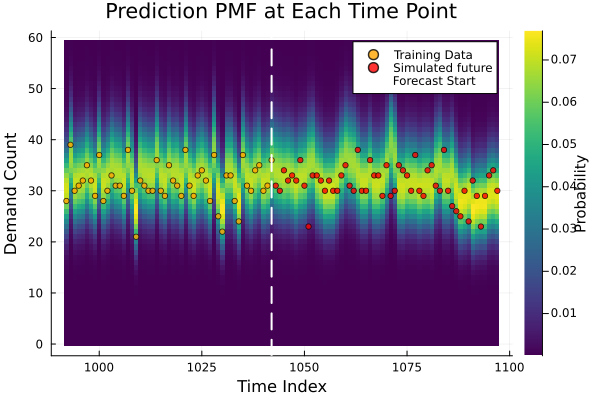

In [25]:
y_dists = results_poi.predictions[:y][end]
max_count = maximum(filter(!ismissing, y_poisson_in)) + 20  

n_show_history = 50 
time_range = max(1, n_train_current - n_show_history):n_total_current

pmf_matrix = zeros(max_count+1, length(time_range))
for (i, t) in enumerate(time_range)
    dist = y_dists[t]  
    for k in 0:max_count
        pmf_matrix[k+1, i] = pdf(dist, k)
    end
end

y_actual = filter(!ismissing, y_poisson_in)

p_pmf = heatmap(time_range, 0:max_count, pmf_matrix,
    xlabel="Time Index", ylabel="Demand Count", 
    title="Prediction PMF at Each Time Point",
    color=:viridis, colorbar_title="Probability")

scatter!(collect(1:n_train_current)[end-n_show_history:end], y_actual[end-n_show_history:end], label="Training Data", color=:orange, markersize=3, alpha=0.8)
scatter!(collect(n_train_current+1:n_total_current), y_poisson_future, label="Simulated future", color=:red, markersize=3, alpha=0.8)
vline!([n_train_current], label="Forecast Start", linestyle=:dash, color=:white, lw=2)
display(p_pmf)


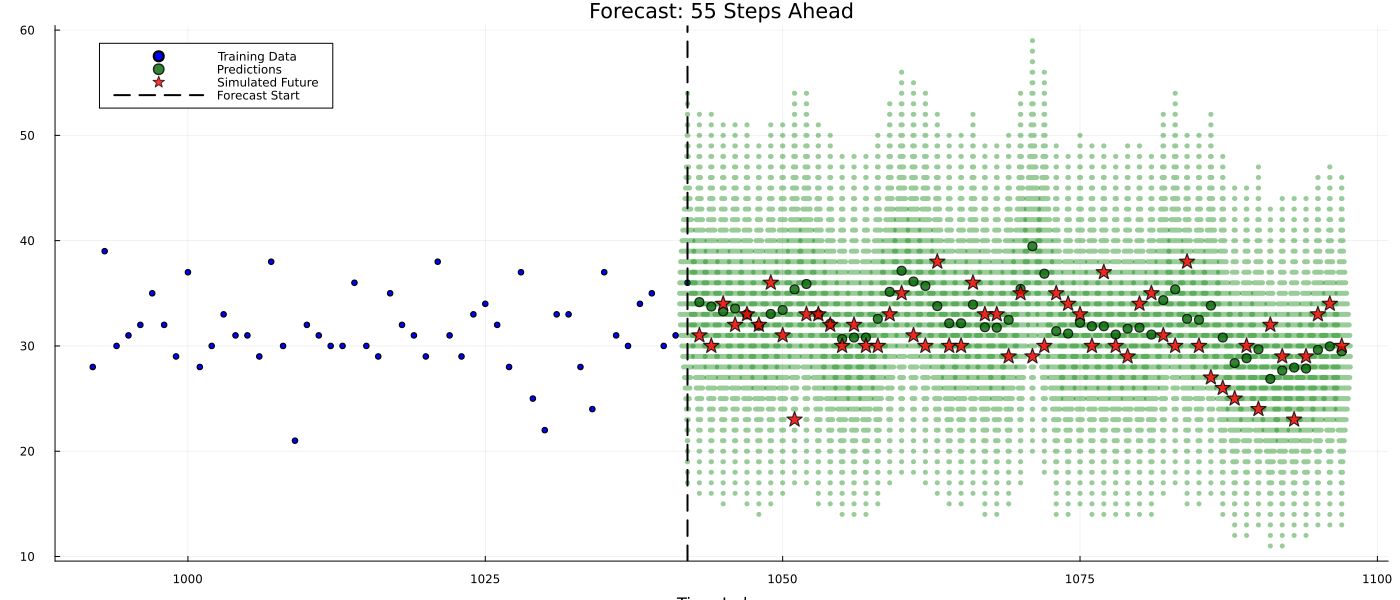

In [26]:
time_stretch = 10.0
prob_scale = 10.0
y_pred_means = mean.(y_dists)

n_train_show = 30
train_start = max(1, n_train_current - n_train_show)

p_pred = plot(xlabel="Time Index", ylabel="Demand", 
    title="Forecast: $(n_predict_current) Steps Ahead",
    size=(1400, 600), legend=:topleft)


scatter!(collect(1:n_train_current)[end-n_show_history:end], y_actual[end-n_show_history:end], label="Training Data", color=:blue, markersize=3, alpha=1.0)

for t in n_train_current:n_total_current
    dist = y_dists[t]
    λ = mean(dist)
    support = max(0, floor(Int, λ-3*sqrt(λ))):ceil(Int, λ+3*sqrt(λ))
    probs = pdf.(dist, support)
    
    for (k, prob) in zip(support, probs)
        plot!([t - prob*prob_scale, t + prob*prob_scale], [k, k], 
            lw=5, alpha=0.4, color=:green, label="")
    end
    
 
end
scatter!(collect(n_train_current+1:n_total_current), y_pred_means[n_train_current+1:n_total_current], 
color=:darkgreen, markersize=5, label="Predictions", alpha=0.8)
scatter!(collect(n_train_current+1:n_total_current), y_poisson_future, color=:red, markersize=8, 
label="Simulated Future", alpha=0.8, markershape=:star5)


vline!([n_train_current], label="Forecast Start", linestyle=:dash, color=:black, lw=2)
display(p_pred)